# Natural Language Processing using the fetch_20newsgroups dataset

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Getting the SKLearn Dataset

from sklearn.datasets import fetch_20newsgroups

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

In this project we'll only work trying to predict four categories of the Sklearn dataset:

- `alt.atheism`
- `talk.religion.misc`
- `comp.graphics`
- `sci.space`

Note that we'll also remove the headers, footers, and quotes using the `remove` keyword argument of the function. 

Feel free to check the [dataset documentation](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) to know more about it. 

In [6]:
# Categories we'll use
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space']

# Setting training data
data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=('headers', 'footers', 'quotes'))

# Setting testing data
data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=('headers', 'footers', 'quotes'))

### Data inspection

We have downloaded a few newsgroup categories and removed headers, footers and quotes.

As we saw before, because this is an sklearn dataset, it comes with pre-split train and test sets (note we were able to call 'train' and 'test' in subset).

Let's check out: 

- What data type is `data_train`?
- What does `data_train` contain? 
- How many data points does `data_train` contain?
- How many data points of each category does `data_train` contain?
- Inspect the first data point, what does it look like?

In [7]:
type(data_train)

sklearn.utils.Bunch

In [8]:
list(data_train.keys())

['data', 'filenames', 'target_names', 'target', 'DESCR']

In [9]:
data_train.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [10]:
# Making sure our  Data and Target columns are equal length

print(len(data_train['data']))
print(len(data_train['target']))

2034
2034


In [11]:
# Let's check what our data actually looks like.

print(data_train['data'][1])



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.


In [12]:
# What does the target variable look like

print(data_train['target'])

[1 3 2 ... 1 0 1]


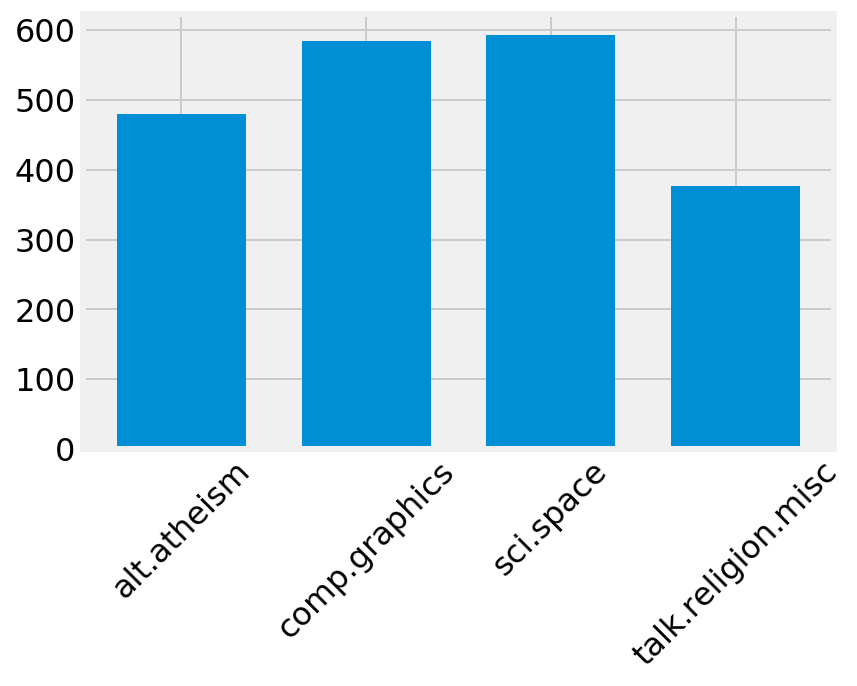

In [13]:
plt.hist(data_train.target,bins=np.linspace(0,4,5),align='left',rwidth=0.7)
plt.yticks(fontsize=16)
plt.xticks(list(range(4)),data_train.target_names,fontsize=16,rotation=45)
plt.show()

### Bag of Words model

Let's train a model using a simple count vectorizer. The bag-of-words model is a simplified representation of the raw data. In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words. Bag-of-words representations discard grammar, order, and structure in the text, but track occurances. To use this model, Sklearn offers a `CountVectorizer` class which returns a sparse matrix and basically does the same specified before, but which has some configurable options. 

#### Transformation and word frequencies

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
# Setting the vectorizer just like we would set a model

cvec = CountVectorizer()

# Fitting the vectorizer on our training data

cvec.fit(data_train['data'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [16]:
# Lets check the length of our data that is in a vectorized state

len(cvec.get_feature_names())

26879

One of the features included by CountVectorizer is the in-built tool of stop_words. In NLP, stop words are words which are filtered out usually after processing our data. Though stop_words in this case refers to the most common words in a language (and more often than not, this is the case). there is no single universal list of stop words used by all natural language processing tools, and indeed not all tools even use such a list.

In [17]:
# Lets use the stop_words argument to remove words like "and, the, a"

cvec = CountVectorizer(stop_words='english')

# Fit our vectorizer using our train data

cvec.fit(data_train['data'])

# Transform training data

cvec_mat = cvec.transform(data_train['data'])

# Let's check some of the words occuring

words = cvec.get_feature_names()
print(words[5000:5020])
print()

# And the number of different words (we'll have approx. 300 words less than previously)

print(len(words))

['brow', 'brown', 'browning', 'browns', 'browse', 'browsing', 'bruce', 'bruces', 'bruise', 'bruised', 'bruises', 'brunner', 'brush', 'brushmapping', 'brushmaps', 'brussel', 'brutal', 'brutally', 'brute', 'bryan']

26576


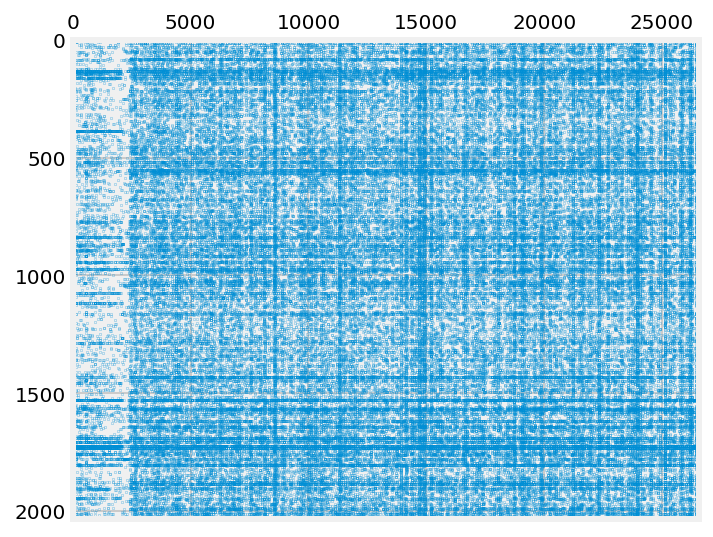

In [20]:
# Now we'll plot the sparsity pattern of our sparsity matrix

# This is a matrix with the following form:

# * 0  1  2  3  4  5 ...
# 0 x1 0  x2 x3 0  x5...
# 1 y1 y2 0  y5 y6 y7...
# 2 z1 z2 z3 z4 z5 z6...
# ......................

# Each column is a word and each row is one piece of text. 
# The values are the ocurrences of each word in the piece of text. For example: x2 = 2 occurrences
# And, to save space, it's saved the following way:

# (0,0) : x1
# (0,2) : x2
# And so...

# The following plot then visualizes the non-zero values of the array

plt.figure(figsize=(5,200))
plt.spy(cvec_mat,markersize=0.000001,aspect=10);

**Let's find several ways of looking at the most common words in the entire dataset**

In [21]:
# Adding up the rows for each columns and creating a DataFrame with the words as column names

a = cvec_mat.sum(axis=0)
pd.DataFrame(a,columns=words).transpose().sort_values(by=0,ascending=False).head(10)

,0
space,1061
people,793
god,745
don,730
like,682
just,675
does,600
know,592
think,584
time,546


**We can filter our sparse matrix by our target type 1 (graphics)**

In [24]:
a = cvec_mat[data_train.target==1].sum(axis=0)
pd.DataFrame(a,columns=words).transpose().sort_values(by=0,ascending=False).head()

,0
image,484
graphics,410
edu,297
jpeg,267
file,265


**Another way of finding the most common words**

In [25]:
# Sort words by frequency using itemgetter

from operator import itemgetter


# Using sorted + itemgetter we can set tuples out of the words and the words count
# and specify through the itemgetter the position in the tuple by which
# we want sorted to sort the container

def word_frequency_sorter(words,counts):
    sort_result = sorted(zip(words,list(counts)),key=itemgetter(1),reverse=True)
    return sort_result

In [26]:
csum = np.array(cvec_mat.sum(axis=0))[0]

In [28]:
df_word_frequency = pd.DataFrame(word_frequency_sorter(words,csum),columns=['word','frequency'])
df_word_frequency.set_index('word',inplace=True)
df_word_frequency.head(10)

,frequency
word,
space,1061
people,793
god,745
don,730
like,682
just,675
does,600
know,592
think,584


**We could do the same in pandas, but that requires transforming to to array**

In [29]:
df_cvec = pd.DataFrame(cvec_mat.toarray(),columns=cvec.get_feature_names())
df_cvec.sum(axis=0).sort_values(ascending=False)[:10]

space     1061
people     793
god        745
don        730
like       682
just       675
does       600
know       592
think      584
time       546
dtype: int64

**And one more way of doing the same using lambda**

In [30]:
df_cvec.apply(lambda x: sum(x)).sort_values(ascending=False).head(10)

space     1061
people     793
god        745
don        730
like       682
just       675
does       600
know       592
think      584
time       546
dtype: int64

#### Plotting the word frequency distribution:

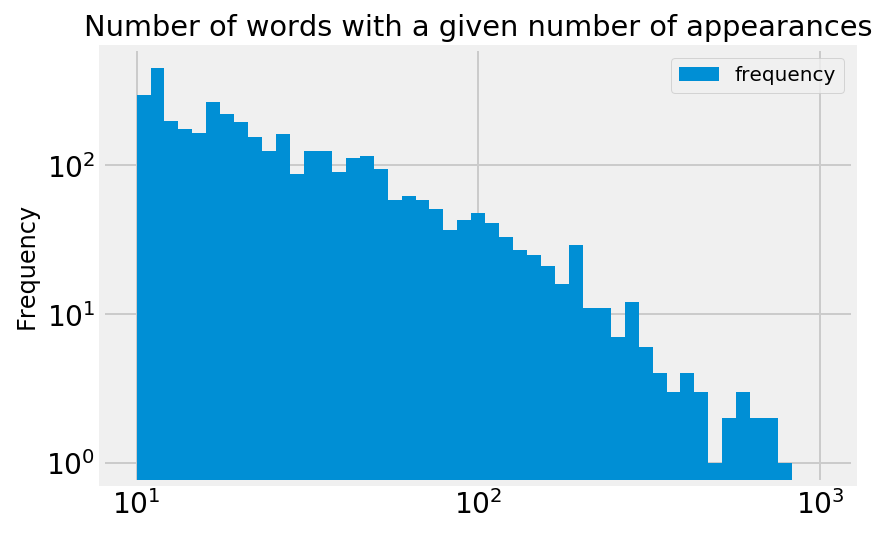

In [32]:
df_word_frequency.plot(kind='hist',
                       bins=np.logspace(1,3,50),
                       loglog=True,
                       title='Number of words with a given number of appearances',
                       fontsize=14)
plt.show()

#### We can also look at the most important words within each category using pandas

In [38]:
df_cvec["target_def"] = data_train.target

In [42]:
df_cvec[df_cvec.target_def == 0].groupby('target_def').sum().transpose()[0].sort_values(ascending=False).head(10)

god        405
people     330
don        262
think      215
just       209
does       207
atheism    199
say        174
believe    163
like       162
Name: 0, dtype: int64

#### Fit a logistic regression model

In [43]:
X_train = cvec_mat
y_train = data_train.target
X_test = cvec.transform(data_test.data)
y_test = data_test.target

In [44]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', multi_class='ovr')
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.9768928220255654
0.7450110864745011


**Creating the confusion matrix with the name of the variables**

In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def docm(y_true, y_pred,labels):
    cm = confusion_matrix(y_true, y_pred)
    cols = ['p_'+c for c in labels]
    df = pd.DataFrame(cm, index=labels, columns=cols)
    return df

In [46]:
docm(y_test,lr.predict(X_test),labels=data_train.target_names)

,p_alt.atheism,p_comp.graphics,p_sci.space,p_talk.religion.misc
alt.atheism,187,16,46,70
comp.graphics,13,345,28,3
sci.space,22,23,333,16
talk.religion.misc,67,14,27,143


In [47]:
print(classification_report(y_test,lr.predict(X_test),target_names=data_train.target_names))

                    precision    recall  f1-score   support

       alt.atheism       0.65      0.59      0.62       319
     comp.graphics       0.87      0.89      0.88       389
         sci.space       0.77      0.85      0.80       394
talk.religion.misc       0.62      0.57      0.59       251

          accuracy                           0.75      1353
         macro avg       0.72      0.72      0.72      1353
      weighted avg       0.74      0.75      0.74      1353



### Using Hashing and TF-IDF

A hash value (or simply hash), also called a message digest, is a number generated from a string of text.
The hash is substantially smaller than the text itself, and is generated by a formula in such a way that it is extremely unlikely that some other text will produce the same hash value. We can think of the hash as a code that represents the original text in a more condensed format.

As we have seen we can set the CountVectorizer dictionary to have a fixed size, only keeping words of certain frequencies, however, we still have to compute a dictionary and hold the dictionary in memory. This could be a problem when we have a large corpus or in streaming applications where we don't know which words we will encounter in the future.

Both problems can be solved using the HashingVectorizer, which converts a collection of text documents to a matrix of occurrences calculated with the hashing trick. Each word is mapped to a feature with the use of a hash function that converts it to a hash. If we encounter that word again in the text, it will be converted to the same hash, allowing us to count word occurence without retaining a dictionary in memory. That's why hashing is a fast and space-efficient way of vectorizing features, i.e. turning arbitrary features into indices in a vector or matrix

The main drawback of this trick is that it's not possible to compute the inverse transform, and thus we lose information on what words the important features correspond to. Also, if the vocabulary is kept fixed and not increased with a growing training set, an adversary may try to invent new words or misspellings that are not in the stored vocabulary so as to circumvent a machine learned filter.

In the following example, we're going to use HashingVectorizer from Sklearn with a simple text: 'This is an example'. We'll see how this technique gives us back a HashingVectorizer object that, when put into a DataFrame, will give us only 4 words with a value larger than 0.

In [48]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

In [49]:
hvec = HashingVectorizer(binary=True,norm=None,alternate_sign=False)
hvec.fit(['This is an example'])

HashingVectorizer(alternate_sign=False, analyzer='word', binary=True,
                  decode_error='strict', dtype=<class 'numpy.float64'>,
                  encoding='utf-8', input='content', lowercase=True,
                  n_features=1048576, ngram_range=(1, 1), norm=None,
                  preprocessor=None, stop_words=None, strip_accents=None,
                  token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None)

In [50]:
hvec

HashingVectorizer(alternate_sign=False, analyzer='word', binary=True,
                  decode_error='strict', dtype=<class 'numpy.float64'>,
                  encoding='utf-8', input='content', lowercase=True,
                  n_features=1048576, ngram_range=(1, 1), norm=None,
                  preprocessor=None, stop_words=None, strip_accents=None,
                  token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None)

In [51]:
# .toarray() returns it in numpy array format.

df = pd.DataFrame(hvec.transform(["This is an example"]).toarray())

df.sort_values(0, ascending=False, axis=1).iloc[:, :20]

,333465,144749,170062,162235,0,699047,699050,699049,699048,699046,699052,699045,699044,699043,699042,699041,699051,699054,699053,699039
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
df.sort_values(0, ascending=False, axis=0).iloc[0, :].value_counts()

0.0    1048572
1.0          4
Name: 0, dtype: int64

#### Let's use now HashingVectorizer with our data

In [53]:
# Setting up a pipeline to run our model

piped_model = make_pipeline(HashingVectorizer(stop_words='english', n_features=2**15),
                      LogisticRegression(solver='lbfgs', multi_class='ovr'))

piped_model.fit(data_train.data, y_train)
y_pred = piped_model.predict(data_test.data)
print(accuracy_score(y_test, y_pred))
print("Number of features:", piped_model.named_steps['hashingvectorizer'].n_features)

0.7398373983739838
Number of features: 32768


#### Trying with Term frequency - inverse document frequency (tf-idf)


A tf-idf score tells us which words are most discriminating between documents. Words that occur a lot in one document but don't occur in many documents contain a great deal of discriminating power.

- This weight is a statistical measure used to evaluate how important a word is to a document in a collection (aka corpus).


- The importance increases with the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

The inverse document frequency is a measure of how much information the word provides, that is, whether the term is common or rare across all documents. It is the logarithmically scaled inverse fraction of the documents that contain the word plus one, obtained by dividing the total number of documents by the number of documents containing the term plus one, and then taking the logarithm of that quotient.

This enhances terms that are highly specific of a particular document, while suppressing terms that are common to most documents.


Term frequency `tf` is the frequency of a certain term in a document:

$$
\mathrm{tf}(t,d) = N_\text{term}
$$

Inverse document frequency `idf` is defined as the frequency of documents that contain that term over the whole corpus (logarithmically scaled and adjusted to give only positive results greater or equal to one):

$$
\mathrm{idf}(t, D) = 1+\log\left(\frac{1+N_\text{Documents}}{1+N_\text{Documents that contain term}}\right)
$$

Term frequency - Inverse Document Frequency (`tf-idf`) is calculated as:

$$
\text{tf-idf}(t,d,D) = \mathrm{tf}(t,d) \cdot \mathrm{idf}(t, D)
$$

Usually the obtained numbers are then rescaled in such a way that the tf-idf vector of each document has Euclidean length one.

To apply this method in an easy way, we're gonna use again another Sklearn tool: TfidfVectorizer

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [55]:
piped_model_2 = make_pipeline(TfidfVectorizer(stop_words='english',
                                      #sublinear_tf=True,
                                      max_df=0.3,
                                      max_features=4000),
                      LogisticRegression())
piped_model_2.fit(data_train.data, y_train)
y_pred = piped_model_2.predict(data_test.data)
print(accuracy_score(y_test, y_pred))
print("Number of features:", len(piped_model_2.steps[0][1].get_feature_names()))

0.7509238728750924
Number of features: 4000


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


## Classifier comparison

Finally, let's try our last TfidfVectorizer with several models, to see which one performs the best:

- KNN
- Logistic Regression
- Decision Trees
- Support Vector Machine
- Random Forest
- Extra Trees

In order to speed up the calculation it's better to vectorize the data only once and then compare the models.

And take into account that all of this models could be further improved using GridSearch.

In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [57]:
models = [KNeighborsClassifier(),
          LogisticRegression(solver='lbfgs', multi_class='ovr'),
          DecisionTreeClassifier(),
          SVC(gamma='scale'),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

tvec = TfidfVectorizer(stop_words='english',
                       #sublinear_tf=True,
                       max_df=0.5,
                       max_features=1000)

tvec.fit(data_train['data'])
X_train = tvec.transform(data_train['data'])
X_test = tvec.transform(data_test['data'])

res = []

for model in models:
    print(model)
    print()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(score)
    print() 
    cm = docm(y_test, y_pred, data_train.target_names)
    print(cm)
    res.append([model, score])
    print() 
    print('-'*60)
    print()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

0.2934220251293422

                    p_alt.atheism  p_comp.graphics  p_sci.space  \
alt.atheism                   137               76           51   
comp.graphics                 147              128           42   
sci.space                     133              111           74   
talk.religion.misc             84               72           37   

                    p_talk.religion.misc  
alt.atheism                           55  
comp.graphics                         72  
sci.space                             76  
talk.religion.misc                    58  

------------------------------------------------------------

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='

## Testing our classifier with some random texts

In [58]:
data_train.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [59]:
def printer(prediction):
    names = data_train.target_names
    print(names[prediction])

In [60]:
# A part of a guardian article on politics 
design = ['Graphic design is the process of visual communication and problem-solving through the use of typography, photography, and illustration. The field is considered a subset of visual communication and communication design, but sometimes the term "graphic design" is used synonymously. Graphic designers create and combine symbols, images and text to form visual representations of ideas and messages. They use typography, visual arts, and page layout techniques to create visual compositions. Common uses of graphic design include corporate design (logos and branding), editorial design (magazines, newspapers and books), wayfinding or environmental design, advertising, web design, communication design, product packaging, and signage.']
tvec_test = tvec.transform(design)
my = model.predict(tvec_test)
printer(my[0])

comp.graphics


In [61]:
# A part of a guardian article on technology
space = ['The Tesla CEO, Elon Musk, is planning to put more than 4,000 satellites in orbit in order to blanket the Earth with internet access. SpaceX, the privateer space company led by Musk, is requesting permission from the US government to operate a massive network of 4,425 satellites - plus “in-orbit spares” - to provide high-speed, global internet coverage. Documents filed with the US Federal Communications Commission (FCC) on Tuesday propose an initial launch of 800 satellites to create an orbiting digital communications array to cover the US, including Puerto Rico and the US Virgin Islands.']
tvec_test = tvec.transform(space)
my = model.predict(tvec_test)
printer(my[0])

sci.space


In [62]:
# The abstract of a physics paper
religion = ['A Victoria councillor has tabled a motion that will ask the city to support a legal challenge of a Quebec law that bans employees from wearing religious symbols at work.']
tvec_test = tvec.transform(religion)
my = model.predict(tvec_test)
printer(my[0])

talk.religion.misc
